In [234]:
import networkx as nx 
import matplotlib.pyplot as plt 
import matplotlib.cm as mplcm
import matplotlib
from matplotlib.gridspec import GridSpec
import numpy as np 
from scipy.stats import linregress
import math
import json
import subprocess
import pickle
from itertools import combinations, product

In [341]:
def generate_colors(k, p):
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=p*(k-1))
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

    c = []
    for i in range(k):
        c.append(matplotlib.colors.to_hex(scalarMap.to_rgba(p*i)))
    return c

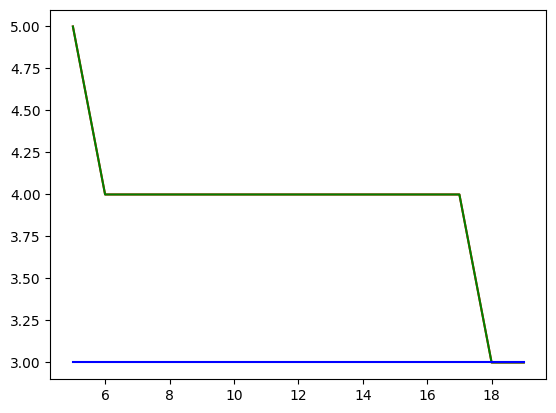

In [25]:
def calculate_density1(k, n):
    return math.ceil(k / (3 - 6/n))

def calculate_density2(k, n):
    return math.floor((k + 3 - 7/n) / (3 - 6/n))

def calculate_density(k):
    return math.ceil((k+1) / 3)

n = list(range(5, 20))
k = 8

y1 = [calculate_density1(k, i) for i in n]
y2 = [calculate_density2(k, i) for i in n]
y3 = [calculate_density(k) for i in n]

plt.plot(n, y1, label='Density 1', color='red')
plt.plot(n, y2, label='Density 2', color='green')
plt.plot(n, y3, label='Density', color='blue')

plt.show()

In [26]:
def random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [27]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

In [28]:
def load_graph_from_file(file_path: str):
    """Load a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

In [29]:
def generate_graph(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./generategraph', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    return load_graph_from_file(filename)

In [30]:
def draw_graph(G: nx.Graph, only_properties = False, name: str = 'BA Graph', pos: dict = None, hist_max_deg: int = None):
    """Draw a graph with node and edge colors.

    Parameters
    ----------
    G : nx.Graph
        The graph to draw.
    """

    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])

    if not only_properties:
        node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
        edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
        if pos == None:
            pos = nx.kamada_kawai_layout(G)
        nx.draw(G, pos, ax=ax0, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
        ax0.set_title(name)

    degrees = [G.degree(n) for n in G.nodes()]

    if hist_max_deg == None:
        hist_max_deg = max(degrees) + 2
    ax1.hist(degrees, bins=range(1, hist_max_deg), align='left', color='deepskyblue')
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    degree_counts = np.bincount(degrees)[1:]
    cdf = np.cumsum(degree_counts[::-1])[::-1]
    cdf = cdf / cdf[0]

    nonzero_indices = degree_counts > 0
    k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
    cdf = cdf[nonzero_indices]

    log_k = np.log(k)
    log_cdf = np.log(cdf)

    slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
    lambda_estimate = -slope

    ax2.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF', color='deepskyblue')
    ax2.plot(k, np.exp(intercept) * k ** slope, label=f'Power-law fit: $\\lambda = {lambda_estimate:.2f}$', color='deeppink')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('CDF')
    ax2.set_title('Degree Distribution and Power-law Fit')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pos, hist_max_deg

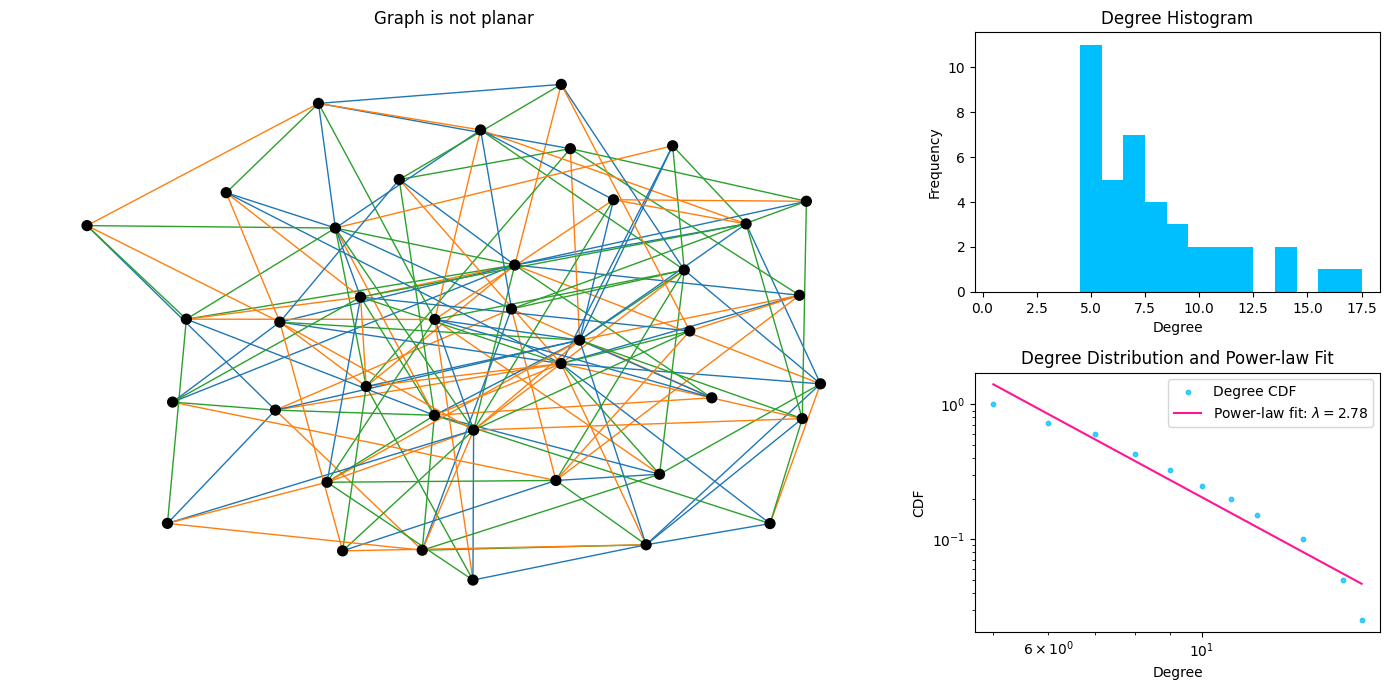

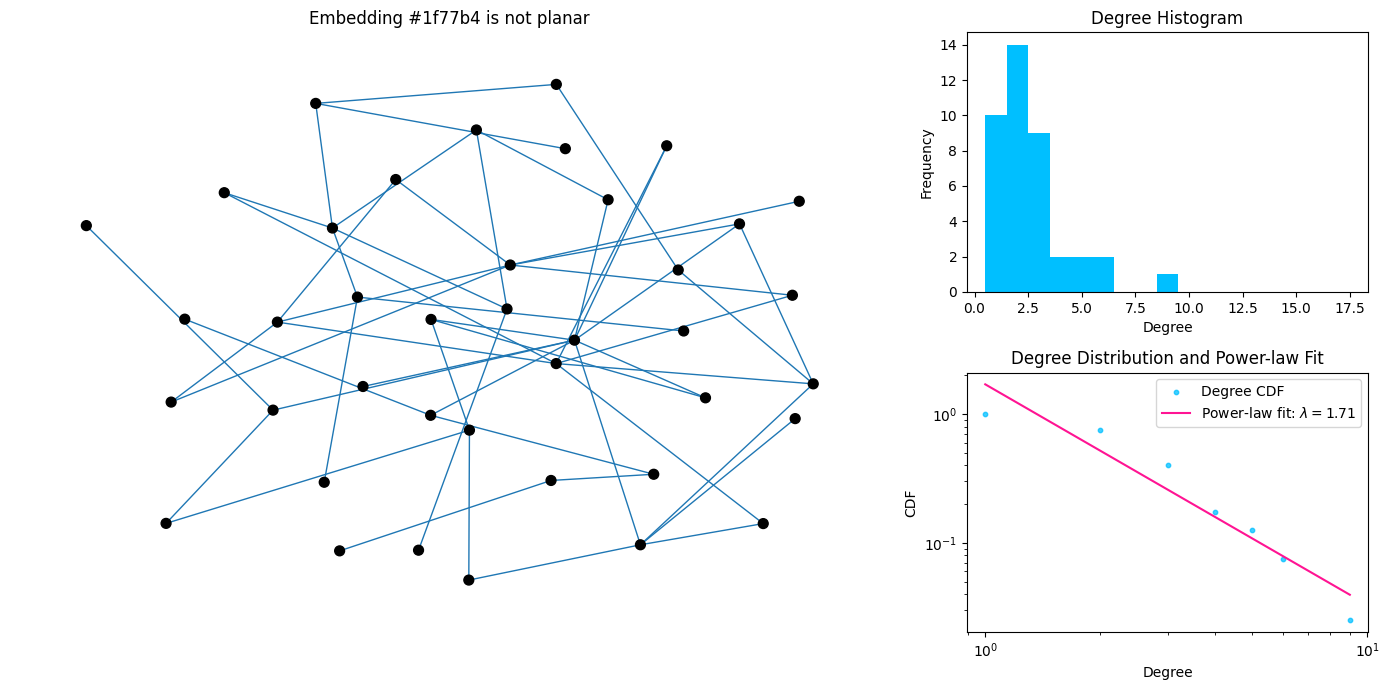

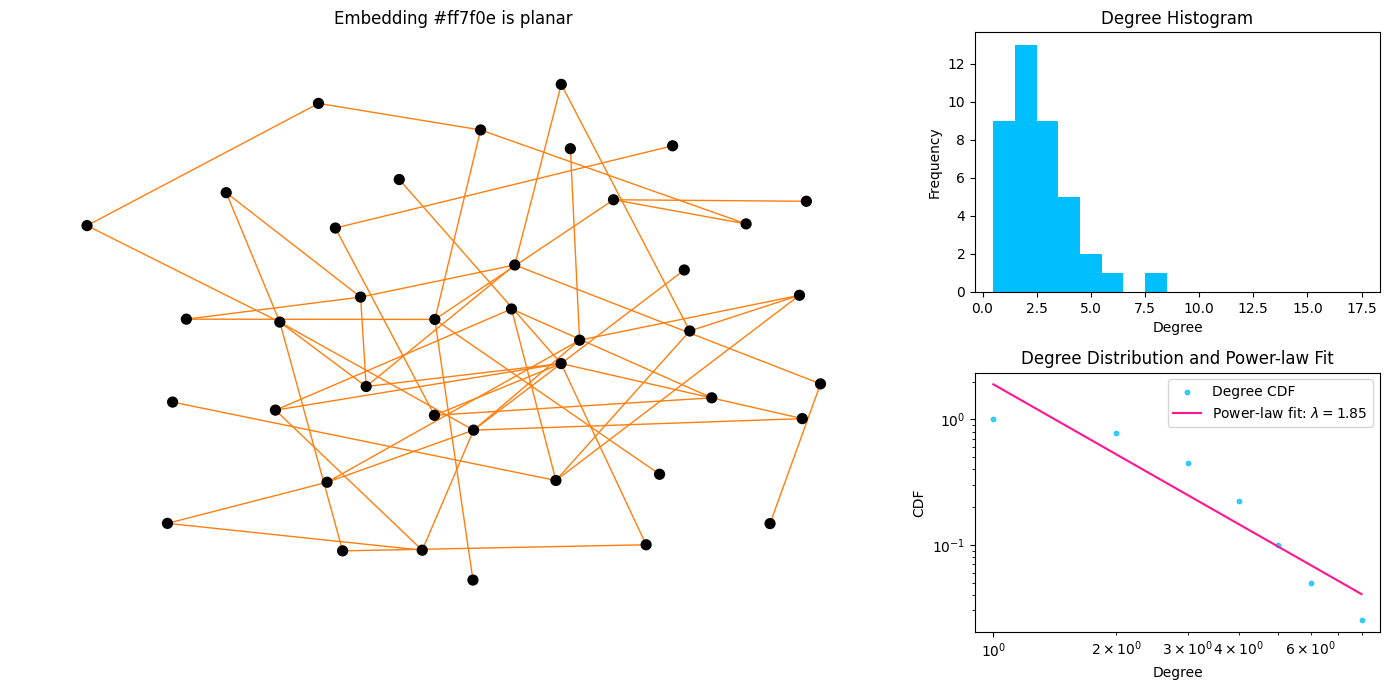

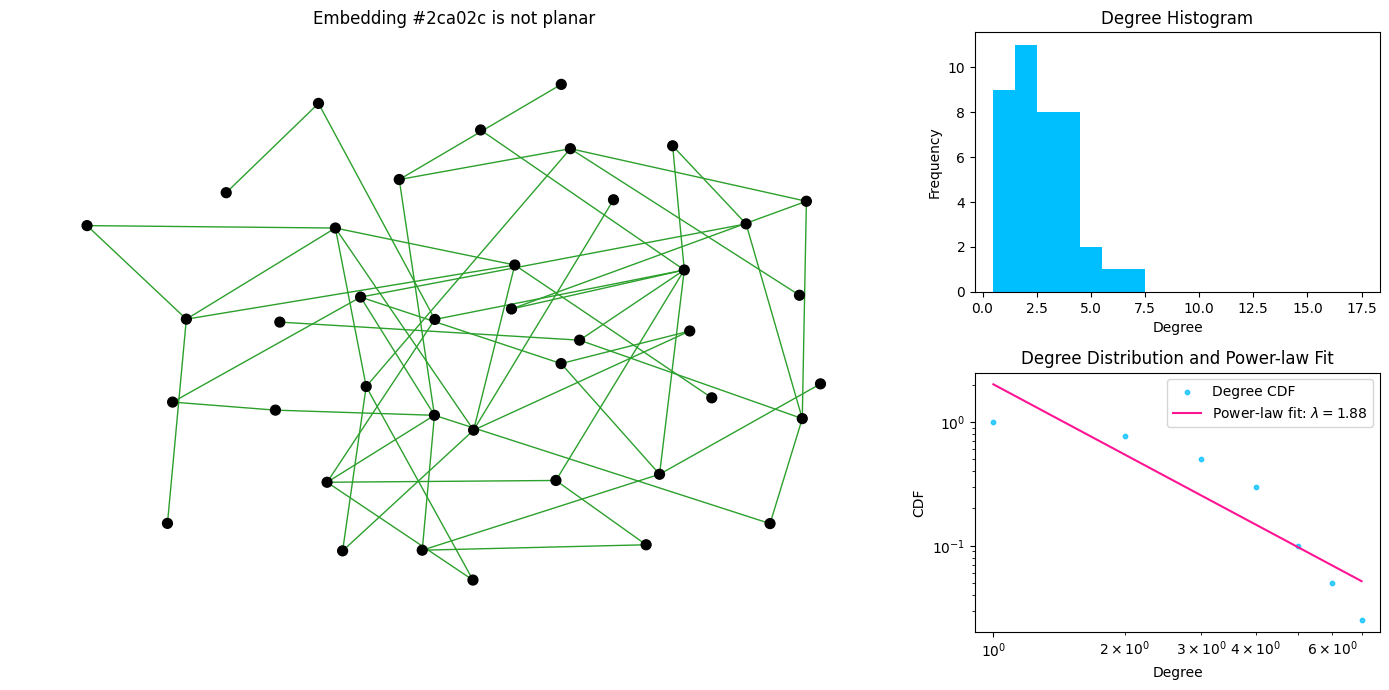

In [31]:
GRAPH_PATH = 'cmake-build-debug/graph1.txt'
EMBEDDING_PATHS = [
    'cmake-build-debug/embedding_#1f77b4.txt',
    'cmake-build-debug/embedding_#ff7f0e.txt',
    'cmake-build-debug/embedding_#2ca02c.txt',
    'cmake-build-debug/embedding_#d62728.txt',
    'cmake-build-debug/embedding_#9467bd.txt',
]
EMBEDDING_NUMBERS = 3

ba = load_graph_from_file('cmake-build-debug/graph1.txt')

planar_info = 'is planar' if nx.is_planar(ba) else 'is not planar'
pos, hist_max_deg = draw_graph(ba, False, 'Graph ' + planar_info, None, None)

for index, embb_path in enumerate(EMBEDDING_PATHS[:EMBEDDING_NUMBERS]):
    embb = load_graph_from_file(embb_path)
    planar_info = ' is planar' if nx.is_planar(embb) else ' is not planar'
    draw_graph(embb, False, 'Embedding ' + embb_path.split('_')[-1][:-4] + planar_info, pos, hist_max_deg)

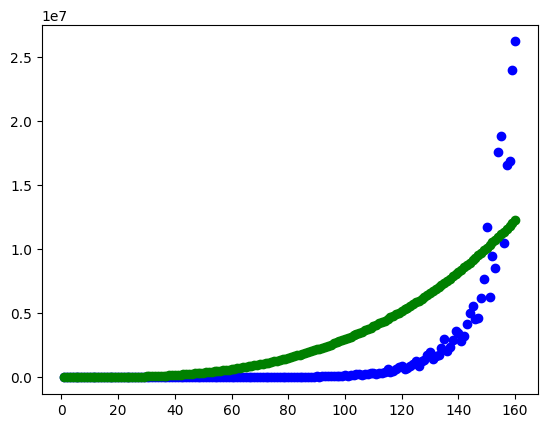

In [32]:
with open('cmake-build-debug/times1.txt') as file:
    xs = []
    ys1 = []
    ys2 = []
    for line in file.readlines():
        x, y = line.strip().split()
        xs.append(int(x))
        ys1.append(int(y))
        ys2.append(3 * int(x) ** 3)
    plt.scatter(xs, ys1, c='blue')
    plt.scatter(xs, ys2, c='green')
    plt.show()

In [33]:
%%script echo skipping 

REPEATS = 10

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 10
NEIGHBOURS_NUMBER_STEP = 1

INITIAL_NODES = 10
FINAL_NODES_LOW = 100
FINAL_NODES_HIGH = 10500
FINAL_NODES_STEP = 500
EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 10
EDGES_PER_NODE_STEP = 1

max_deg_data = {}
density_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    max_deg_data_per_nn = {}
    density_data_per_nn = {}
    for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH + 1, EDGES_PER_NODE_STEP):
        print(f'm = {m}')
        graph_size = []
        max_deg = []
        avg_deg = []
        for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH + 1, FINAL_NODES_STEP):
            max_deg_sum = 0
            avg_deg_sum = 0
            for _ in range(REPEATS):
                graph = generate_graph(INITIAL_NODES, n, m)

                degree_dict = dict(graph.degree())
                top_degree_node = max(degree_dict, key=degree_dict.get)

                nodes_within_k_distance = nx.single_source_shortest_path_length(graph, top_degree_node, cutoff=nn)
                subgraph_nodes = list(nodes_within_k_distance.keys())
                subgraph = graph.subgraph(subgraph_nodes)

                max_deg_sum += graph.degree(top_degree_node)
                avg_deg_sum += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            
            graph_size.append(n)
            max_deg.append(max_deg_sum / REPEATS)
            avg_deg.append(avg_deg_sum / REPEATS)

        max_deg_data_per_nn[m] = {'graph_size': graph_size, 'max_deg': max_deg}
        density_data_per_nn[m] = {'graph_size': graph_size, 'avg_deg': avg_deg}

    max_deg_data[nn] = max_deg_data_per_nn
    density_data[nn] = density_data_per_nn

with open('neighbour-max-deg.pkl', 'wb') as f:
    pickle.dump(max_deg_data, f)

with open('neighbour-density.pkl', 'wb') as f:
    pickle.dump(density_data, f)

skipping


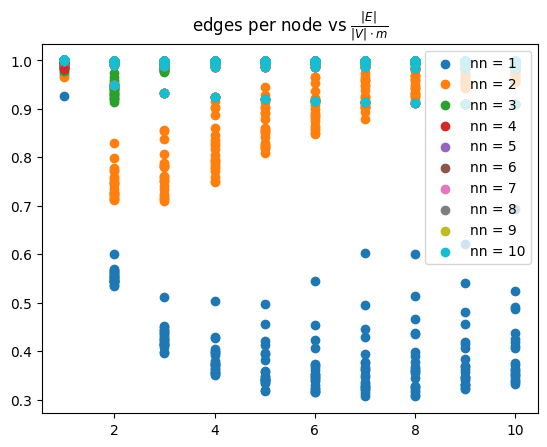

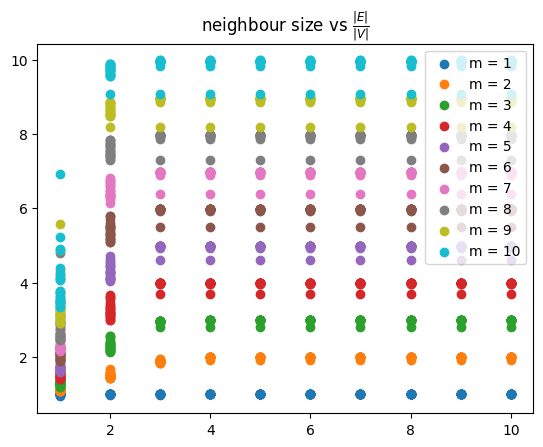

In [34]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

with open('neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

# for nn in nn_values:
#     for m in m_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for nn in nn_values:
#     for m in m_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

for nn in nn_values:
    x = []
    y = []
    for m in m_values:
        x.extend([m] * len(density_data[nn][m]['avg_deg']))
        y.extend([d/m for d in density_data[nn][m]['avg_deg']])
    plt.scatter(x, y, label=f'nn = {nn}')
plt.title(r"edges per node vs $\frac{|E|}{|V| \cdot m}$")
plt.legend(loc='upper right')
plt.show()

for m in m_values:
    x = []
    y = []
    for nn in nn_values:
        x.extend([nn] * len(density_data[nn][m]['avg_deg']))
        y.extend(density_data[nn][m]['avg_deg'])
    plt.scatter(x, y, label=f'm = {m}')
plt.title(r"neighbour size vs $\frac{|E|}{|V|}$")
plt.legend(loc='upper right')
plt.show()

# nn_vals = []
# m_vals = []
# y_vals = []
# for nn in nn_values:
#     for m in m_values:
#         for i in range(len(density_data[nn][m]['graph_size'])):
#             nn_vals.append(nn)
#             m_vals.append(m)
#             y_vals.append(density_data[nn][m]['avg_deg'][i])

# plt.scatter(m_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs edges per node")
# plt.show()

# plt.scatter(nn_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs neighbour size")
# plt.show()


In [35]:
%%script echo skipping 

MAX_DEG_X_FUN = lambda nn, m, n, max_deg: n
MAX_DEG_Y_FUN = lambda nn, m, n, max_deg: max_deg / math.sqrt(n)

with open('neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

nn_values = list(max_deg_data.keys())
m_values = list(max_deg_data[nn_values[0]].keys())
n_values = max_deg_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(MAX_DEG_X_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
            y.append(MAX_DEG_Y_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{max deg}{f{|V|}}$ for neighbour size = " + str(nn))
    plt.legend(loc='lower right')
    plt.show()

skipping


In [36]:
%%script echo skipping 

DENSITY_X_FUN = lambda nn, m, n, density: n
DENSITY_Y_FUN = lambda nn, m, n, density: density

with open('neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(DENSITY_X_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
            y.append(DENSITY_Y_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|} \cdot \frac{1}{f(|V|)}$ for neighbour size = " + str(nn))
    plt.legend()
    plt.show()

skipping


In [37]:
%%script echo skipping 

REPEATS = 10

N0 = 10
N = 10000
M = 3

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 3
NEIGHBOURS_NUMBER_STEP = 1

TOP_DEGREES_NUMBER = 50

density_per_degree_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    average_density_per_degree = {}
    average_density_per_degree_counter = {}

    for _ in range(REPEATS):
        graph = generate_graph(N0, N, M)
        degree_dict = dict(graph.degree())
        distinct_degrees = sorted(list(set(degree_dict.values())))[::-1][:TOP_DEGREES_NUMBER]

        for distinct_degree in distinct_degrees:
            if not distinct_degree in average_density_per_degree:
                average_density_per_degree[distinct_degree] = 0
                average_density_per_degree_counter[distinct_degree] = 0

            node_with_degree = [node for node in degree_dict if degree_dict[node] == distinct_degree][0]
            nodes_within_k_distance = nx.single_source_shortest_path_length(graph, node_with_degree, cutoff=nn)
            subgraph_nodes = list(nodes_within_k_distance.keys())
            subgraph = graph.subgraph(subgraph_nodes)
            average_density_per_degree[distinct_degree] += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            average_density_per_degree_counter[distinct_degree] += 1

    degrees = []
    densities = []
    for degree in average_density_per_degree:
        degrees.append(degree)
        densities.append(average_density_per_degree[degree] / average_density_per_degree_counter[degree])
    density_per_degree_data[nn] = {'degrees': degrees, 'densities': densities}    

with open('neighbour-density-per-degree.pkl', 'wb') as f:
    pickle.dump(density_per_degree_data, f)

skipping


In [38]:
%%script echo skipping 

with open('neighbour-density-per-degree.pkl', 'rb') as f:
    density_per_degree_data = pickle.load(f)

for nn, serie in density_per_degree_data.items():
    xs = []
    ys = []
    for i, y in enumerate(serie['densities']):
        xs.append(serie['degrees'][i])
        ys.append(y)
    plt.scatter(xs, ys, label=f'nn = {nn}')
plt.legend()
plt.show()

skipping


In [39]:
%%script echo skipping 

REPEATS = 10

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 100
FINAL_NODES_STEP = 1

EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

K5 = nx.complete_graph(5)
K33 = nx.complete_bipartite_graph(3, 3)

def find_5_node_cliques(G):
    cliques = []
    for nodes in nx.find_cliques(G):
        if len(nodes) == 5:
            cliques.append(G.subgraph(nodes))
    return cliques

def find_3_full_bipartite(G):
    matcher = nx.isomorphism.GraphMatcher(G, K33)
    K33_subgraphs = []
    
    for subgraph in matcher.subgraph_isomorphisms_iter():
        K33_subgraphs.append(nx.subgraph(G, subgraph.keys()))
    
    return K33_subgraphs

def is_k5_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

    return len(find_5_node_cliques(contracted_graph)) > 0

def is_k33_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

        
    return len(find_3_full_bipartite(contracted_graph)) > 0

planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {
        'size': {},
        'max_deg': {}
    }
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        planarity_data[m]['size'][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for _ in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
            if not max_deg in planarity_data[m]['max_deg']:
                planarity_data[m]['max_deg'][max_deg] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}

            if is_planar:
                planarity_data[m]['size'][n]['planar'] += 1
                planarity_data[m]['max_deg'][max_deg]['planar'] += 1
            else:
                if is_k5_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k5'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k5'] += 1

                if is_k33_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k33'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k33'] += 1


with open('planarity.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

skipping


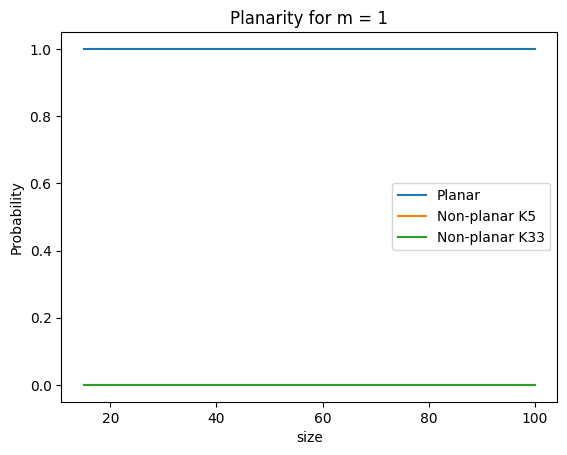

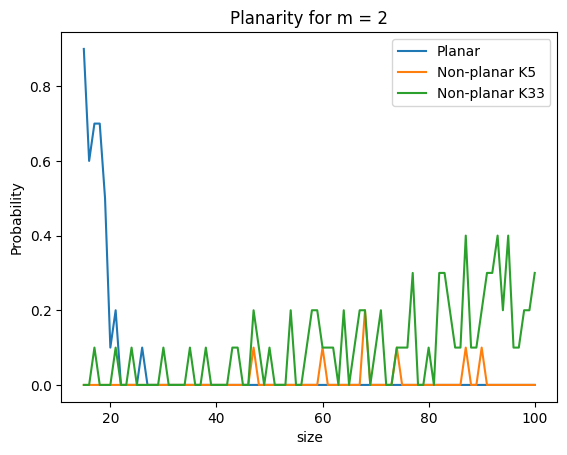

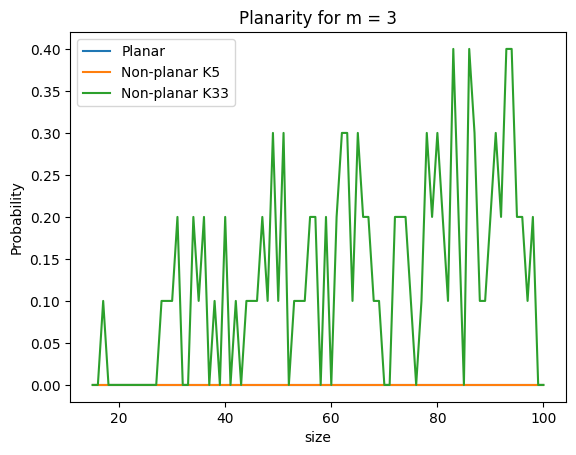

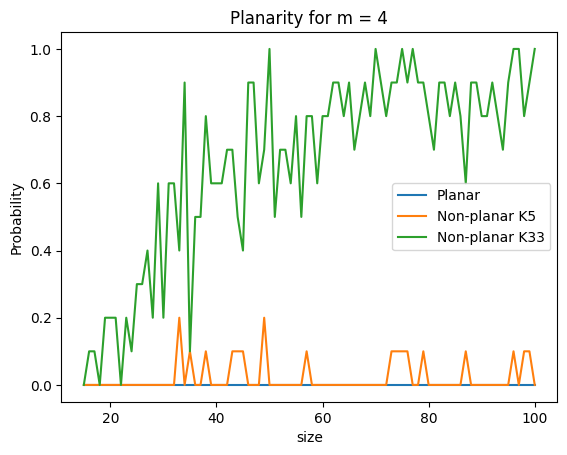

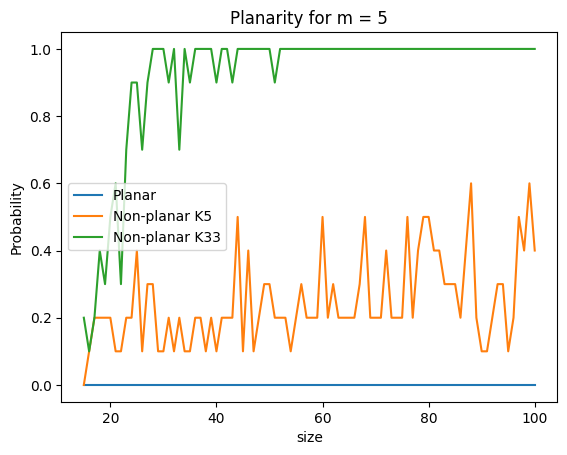

In [40]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
X_PARAM = 'size'
REPEATS = 10

with open('planarity.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data[X_PARAM].items():
        x.append(n)
        y_planar.append(serie['planar'] / REPEATS)
        y_non_planar_k5.append(serie['non-planar-k5'] / REPEATS)
        y_non_planar_k33.append(serie['non-planar-k33'] / REPEATS)
        s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
    
    plt.plot(x, [y for y in y_planar], label='Planar', color=COLORS[0])
    plt.plot(x, [y for y in y_non_planar_k5], label='Non-planar K5', color=COLORS[1])
    plt.plot(x, [y for y in y_non_planar_k33], label='Non-planar K33', color=COLORS[2])
    plt.title(f"Planarity for m = {m}")
    plt.xlabel(X_PARAM)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

In [213]:
def has_cycle_of_length_n(graph, n):
    def dfs(node, visited, path):
        visited.add(node)
        path.append(node)

        if len(path) > n:
            visited.remove(node)
            path.pop()
            return False

        for neighbor in graph.get(node, []):
            if neighbor == path[0] and len(path) == n:
                return True
            if neighbor not in visited:
                if dfs(neighbor, visited, path):
                    return True

        visited.remove(node)
        path.pop()
        return False

    for node in graph:
        if dfs(node, set(), []):
            return True

    return False

def has_clique_of_size_n(graph, n):
    if len(graph.keys()) != n:
        return False
    
    for _, value in graph.items():
        if len(value) != n-1:
            return False
        
    return True

def has_complete_bipartite_of_size_n(graph, n):
    for node in graph:
        if len(graph[node]) != n//2:
            return False
        
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    return nx.bipartite.is_bipartite(G)

def count_in_out_degrees_(graph):
    in_degrees = {node: 0 for node in graph}
    out_degrees = {node: 0 for node in graph}
    for node, neighbors in graph.items():
        in_degrees[node] = len([n for n in neighbors if n > node])
        out_degrees[node] = len([n for n in neighbors if n < node])

    return in_degrees, out_degrees

def find_combinations_with_repeats_(target):
    def backtrack(start, path, target):
        if target == 0:
            if len(path) > 0:
                result.append(path)
            return
        for i in range(start, target + 1):
            if i > target:
                break
            backtrack(i, path + [i], target - i)
    
    result = []
    backtrack(1, [], target)
    return result

def find_posibilities_(in_degrees, out_degrees):
    posibilities = {}
    for key in in_degrees.keys():
        posibilities[key] = {}
        posibilities[key]['out'] = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(out_degrees[key])])
        
    for key, value in in_degrees.items():
        all_combinations = find_combinations_with_repeats_(value)
        
        posibilities[key]['in'] = []
        for comb in all_combinations:
            factor = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(len(comb))])
            coeff = math.factorial(len(comb))
            for k in set(comb):
                coeff //= math.factorial(comb.count(k))
            if coeff != 1:
                posibilities[key]['in'].append((str(coeff) + factor, comb))
            else:
                posibilities[key]['in'].append((str(factor), comb))
            print('--> ', key, ': ', comb, ' = ', str(coeff) + factor)

    return posibilities


def count_(V, E, check):
    groups = [
        [chr(ord('A') + i)] for i in range(V)
    ]

    group_pairs = list(combinations(range(len(groups)), 2))

    all_edges = []
    for (i, j) in group_pairs:
        for node1, node2 in product(groups[i], groups[j]):
            all_edges.append((node1, node2))

    sorted_all_edges = []
    for edge in all_edges:
        if edge[0][0] > edge[1][0]:
            sorted_all_edges.append(edge)
        else:
            sorted_all_edges.append((edge[1], edge[0]))

    edges_groups = list(combinations(sorted_all_edges, E))

    counter = 0
    for group in edges_groups:
        graph = {chr(ord('A') + i) : [] for i in range(V)}
        for edge in group:
            e1 = edge[0][0]
            e2 = edge[1][0]
            graph[e1].append(e2)
            graph[e2].append(e1)

        if check(graph, V):
            counter += 1
            print(count_in_out_degrees_(graph))
            print(find_posibilities_(*count_in_out_degrees_(graph)))
            for key, values in find_posibilities_(*count_in_out_degrees_(graph)).items():
                value_out = values['out']
                values_in = values['in']
                if len(values_in) == 0:
                    values_in = [('', '[]')]
                for value_in in values_in:
                    print(key + ': ' + value_in[0] + value_out + ': ' + str(value_in[1]))
    
    print(counter)
    print()

# count_(3, 3, has_cycle_of_length_n)
# count_(4, 4, has_cycle_of_length_n)
count_(5, 10, has_clique_of_size_n)
# count_(6, 9, has_complete_bipartite_of_size_n)

({'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}, {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})
-->  A :  [1, 1, 1, 1]  =  1m(m-1)(m-2)(m-3)
-->  A :  [1, 1, 2]  =  3m(m-1)(m-2)
-->  A :  [1, 3]  =  2m(m-1)
-->  A :  [2, 2]  =  1m(m-1)
-->  A :  [4]  =  1m
-->  B :  [1, 1, 1]  =  1m(m-1)(m-2)
-->  B :  [1, 2]  =  2m(m-1)
-->  B :  [3]  =  1m
-->  C :  [1, 1]  =  1m(m-1)
-->  C :  [2]  =  1m
-->  D :  [1]  =  1m
{'A': {'out': '', 'in': [('m(m-1)(m-2)(m-3)', [1, 1, 1, 1]), ('3m(m-1)(m-2)', [1, 1, 2]), ('2m(m-1)', [1, 3]), ('m(m-1)', [2, 2]), ('m', [4])]}, 'B': {'out': 'm', 'in': [('m(m-1)(m-2)', [1, 1, 1]), ('2m(m-1)', [1, 2]), ('m', [3])]}, 'C': {'out': 'm(m-1)', 'in': [('m(m-1)', [1, 1]), ('m', [2])]}, 'D': {'out': 'm(m-1)(m-2)', 'in': [('m', [1])]}, 'E': {'out': 'm(m-1)(m-2)(m-3)', 'in': []}}
-->  A :  [1, 1, 1, 1]  =  1m(m-1)(m-2)(m-3)
-->  A :  [1, 1, 2]  =  3m(m-1)(m-2)
-->  A :  [1, 3]  =  2m(m-1)
-->  A :  [2, 2]  =  1m(m-1)
-->  A :  [4]  =  1m
-->  B :  [1, 1, 1]  =  1m(m-1)(m-2)
-->  B :

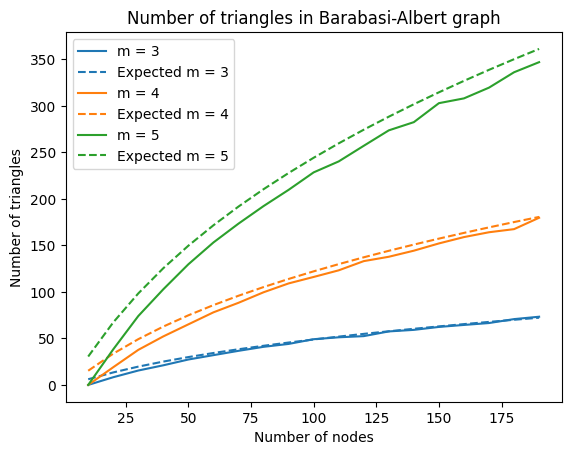

In [215]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def k3_expected_number(n, m):
    return (m-1) * m * (m+1) * math.log(n)**3 / 48

for m in [3, 4, 5]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 200, 10):
            print(n)
            n_sum = 0
            for _ in range(1000):
                G = generate_graph(10, n, m)
                triangles = nx.triangles(G)
                total_triangles = sum(triangles.values()) // 3
                n_sum += total_triangles
            x.append(n)
            y.append(n_sum / 1000)
        pickle.dump((x, y), open(f'k3_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'k3_data_m_{m}.pkl', 'rb'))
    
    exp_y = [k3_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of triangles in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of triangles")
plt.legend()
plt.show()

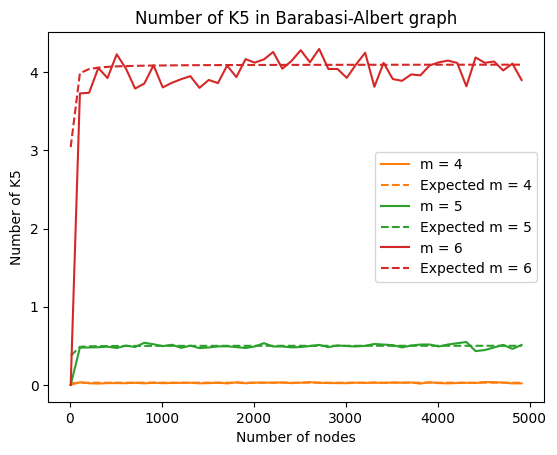

In [206]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s

def k5_expected_number(n, m):
    return (m-3) * (m-2)**2 * (m-1)**3 * (m+1)**2 * (m+2) * (m**3 + 29*m - 6) / m**2 * harmonic_number(2, n)**5 / 73728000

for m in [4,5,6]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(1000):
                G = generate_graph(10, n, m)
                cliques = list(nx.enumerate_all_cliques(G))
                k5_cliques = [clique for clique in cliques if len(clique) == 5]
                n_sum += len(k5_cliques)
            x.append(n)
            y.append(n_sum / 1000)
        pickle.dump((x, y), open(f'k5_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'k5_data_m_{m}.pkl', 'rb'))
        
    exp_y = [k5_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K5 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K5")
plt.legend()
plt.show()

In [44]:
%%script echo skipping 

COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def get_complete_bipartite_subgraphs(graph, k):
    assert len(graph) >= 2*k, "Graph must be larger than 2k!"
    output = []
    for nodes in combinations(graph.nodes, 2*k):
        subgraph = graph.subgraph(nodes)
        try:
            s1, s2 = nx.bipartite.sets(subgraph)
            if (len(s1) == k) & (len(s2) == k) & (len(subgraph.edges) == k*k):
                output.append(subgraph)
        except:
            pass
    return output

def k33_expected_number(n, m):
    return m**6 * math.log(n)**6 / 576000000

for m in [4]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(10):
                G = generate_graph(10, n, m)
                k33 = get_complete_bipartite_subgraphs(G, 3)
                # for p_k33 in possible_k33:
                #     subgraph = G.subgraph(p_k33)
                #     for partition in combinations(p_k33, 3):
                #         set1 = set(partition)
                #         set2 = set(p_k33) - set1
                #         if nx.is_bipartite(subgraph) and all(subgraph.has_edge(u, v) for u in set1 for v in set2):
                #             n_sum += 1
                
            x.append(n)
            y.append(n_sum / 2 / 100)
    else:
        x, y = pickle.load(open(f'k33_data_m_{m}.pkl', 'rb'))

    exp_y = [k33_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K33 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K33")
plt.legend()
plt.show()

skipping


In [217]:
G = nx.complete_graph(4)
triangles = nx.triangles(G)
total_triangles = sum(triangles.values()) // 3
print(total_triangles)

G = nx.complete_graph(5)
cliques = list(nx.enumerate_all_cliques(G))
k5_cliques = [clique for clique in cliques if len(clique) == 5]
print(len(k5_cliques))

G = nx.complete_bipartite_graph(3, 3)
cnt = 0
possible_k33 = [combination for combination in combinations(G.nodes(), 6) if nx.is_connected(G.subgraph(combination))]
for p_k33 in possible_k33:
    subgraph = G.subgraph(p_k33)
    for partition in combinations(p_k33, 3):
        set1 = set(partition)
        set2 = set(p_k33) - set1
        if nx.is_bipartite(subgraph) and all(subgraph.has_edge(u, v) for u in set1 for v in set2):
            cnt += 1
print(cnt)

4
1
2


In [578]:
# Testing correspendence between G(n, m) and G(n*m, 1)COLORS = generate_colors(FINAL_N, 2)

def generate_g1_nm(n0, n, m, colors=None):
    fn = n0 + (n - n0) * m
    graph = generate_graph(n0, fn, 1)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        
        for i in range(n0, fn, m):
            for j in range(m):
                graph.nodes[i + j]['color'] = colors[color_index]
            color_index += 1

    return graph

def fold_g1_nm_to_gm_n(graph, n0, n, m):
    def convert(i):
        return i if i < n0 else n0 + (i - n0) // m

    new_graph = nx.Graph()
    
    fn = n0 + (n - n0) * m
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']

    for i in range(n0, fn, m):
        for j in range(m):
            old_id = i + j
            new_id = convert(i)
            
        new_graph.add_node(new_id)
        new_graph.nodes[new_id]['color'] = graph.nodes[old_id]['color']


    converted_edges = [(convert(u), convert(v)) for (u, v) in graph.edges()]
    converted_edges = [(u,v) if u > v else (v,u) for (u,v) in converted_edges]
    initial_edges = [(u,v) for (u,v) in converted_edges if u < n0 and v < n0]
    rest_nodes = [(u,v) for (u,v) in converted_edges if u >= n0 or v >= n0]
    rest_nodes = sorted(rest_nodes, key=lambda x: (x[0], x[1]))

    for u,v in initial_edges:
        new_graph.add_edge(u,v)

    for u,v in rest_nodes:
        new_graph.add_edge(u,v)

    return new_graph
    

# N0 = 10
# N = 100
# M = 5

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_g1_nm(N0, N, M, colors)
# merged_graph = fold_g1_nm_to_gm_n(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(merged_graph)

In [581]:
def generate_gm_n(n0, n, m, colors=None):
    if (n - n0) % m != 0:
        raise ValueError("n - n0 must be divisible by m")
    
    graph = generate_graph(n0, n, m)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        for i in range(n0, n):
            graph.nodes[i]['color'] = colors[color_index]
            color_index += 1

    return graph


def unfold_gm_n_to_g1_nm(graph, n0, n, m):
    new_graph = nx.Graph()

    nodes_translation = {}
    
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']
        
    for i in range(n0, n):
        for j in range(n0 + m * (i - n0), n0 + m * (i - n0 + 1)):
            new_graph.add_node(j)
            new_graph.nodes[j]['color'] = graph.nodes[i]['color']

    edges_with_endpoints_less_than_n0 = [(u, v) for u, v in graph.edges() if u < n0 and v < n0]
    for e1, e2 in edges_with_endpoints_less_than_n0:
        new_graph.add_edge(e1, e2)
        nodes_translation[e1] = e1
        nodes_translation[e2] = e2

    for node in range(n0, n):
        edges_to_remove = [(u,v) for u,v in graph.edges(node) if v < u]

        for index, edge in enumerate(edges_to_remove):
            new_start_id = n0 + m * (node - n0)
            new_graph.add_edge(new_start_id + index, nodes_translation[edge[1]])
            nodes_translation[edge[0]] = new_start_id

    return new_graph

# N0 = 5
# N = 101
# M = 3

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_gm_n(N0, N, M, colors)
# divided_graph = unfold_gm_n_to_g1_nm(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(divided_graph)

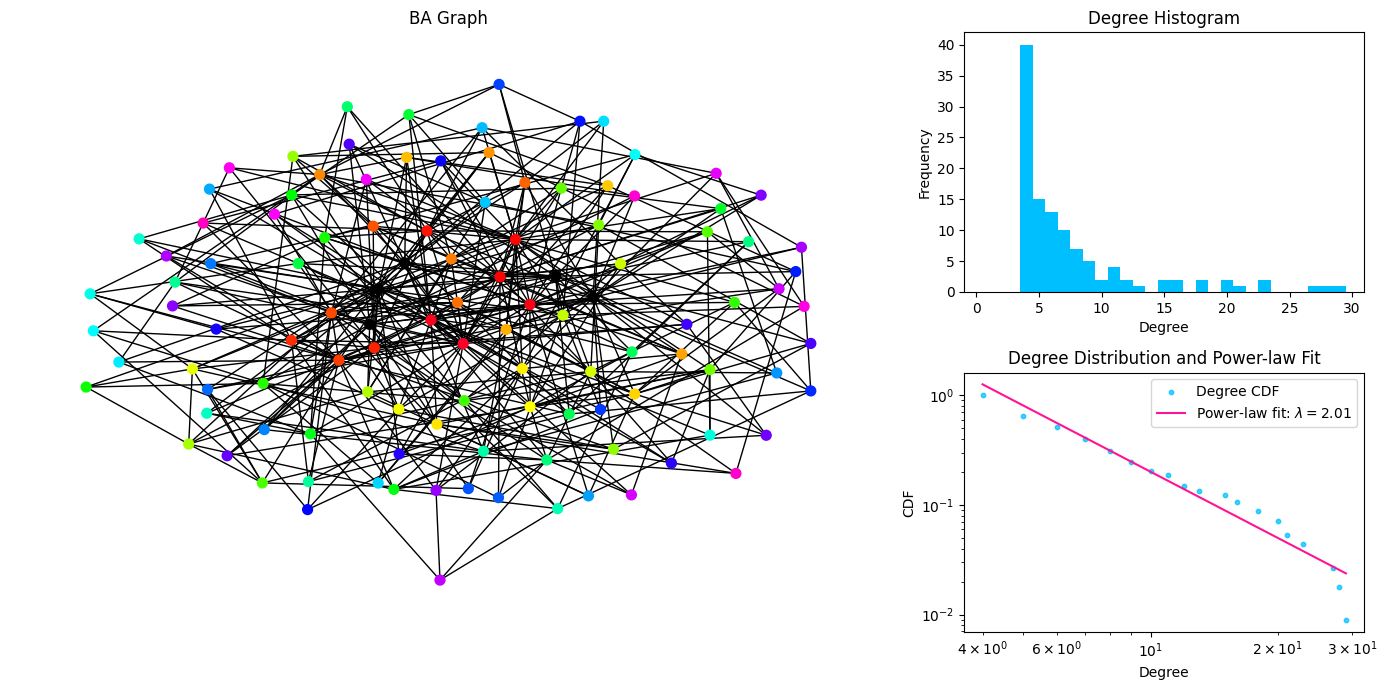

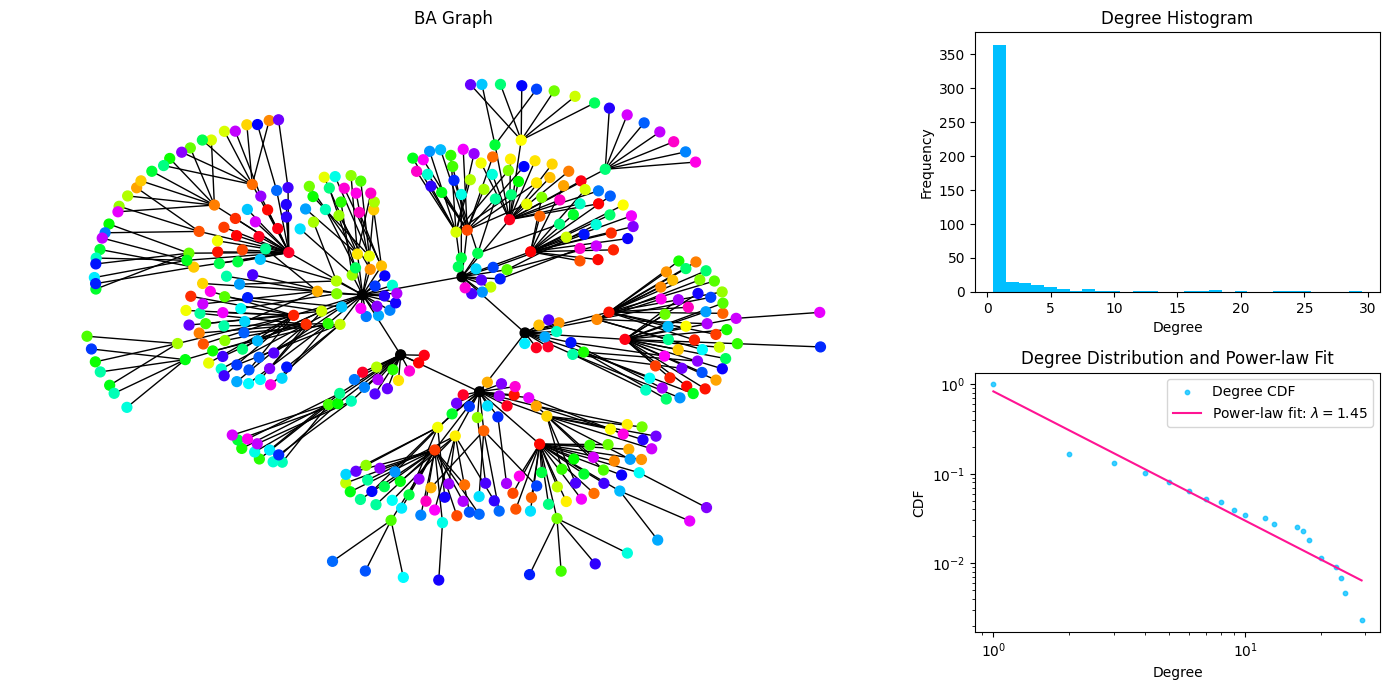

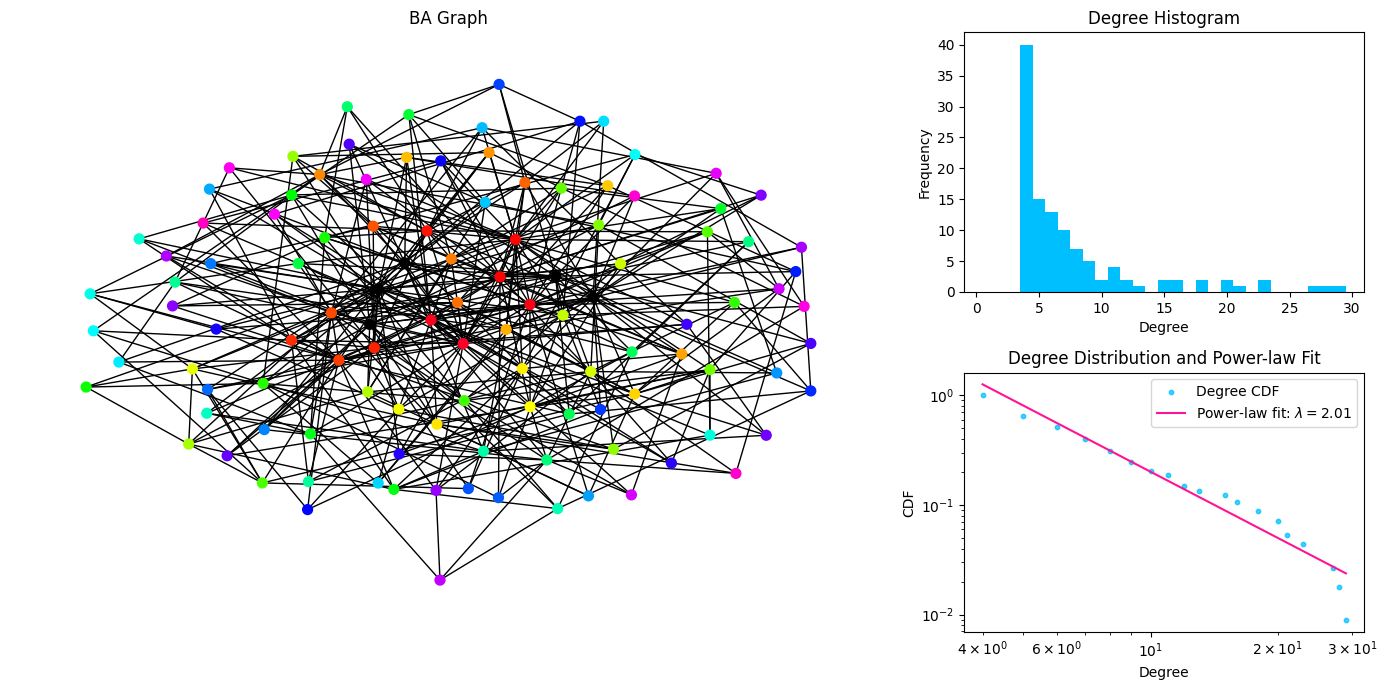

({0: array([-0.19579141,  0.10572782]),
  1: array([0.21702495, 0.15451447]),
  2: array([-0.13456124,  0.20533945]),
  3: array([0.30436466, 0.07376539]),
  4: array([-0.21622267, -0.02887739]),
  5: array([ 0.00169699, -0.10173193]),
  6: array([-0.07343674, -0.01196584]),
  7: array([0.1572682 , 0.04688948]),
  8: array([0.08759915, 0.15211826]),
  9: array([0.12351256, 0.29413865]),
  10: array([-0.0825887 ,  0.32666612]),
  11: array([-0.20549532, -0.11741584]),
  12: array([-0.39851632, -0.08895918]),
  13: array([-0.28806782, -0.16445187]),
  14: array([-0.30539619,  0.01537591]),
  15: array([-0.20796728,  0.34443304]),
  16: array([0.14550487, 0.51012819]),
  17: array([-0.01155685,  0.05442386]),
  18: array([-0.0259487 ,  0.22040653]),
  19: array([-0.33268471,  0.5404092 ]),
  20: array([0.06195012, 0.62418398]),
  21: array([ 0.51085884, -0.14078836]),
  22: array([ 0.10172026, -0.04802941]),
  23: array([-0.13012862,  0.60586517]),
  24: array([0.3383224 , 0.49836562]),
 

In [582]:
N0 = 5
N = 113
M = 4

colors = ['#000000'] + generate_colors(N - N0, 2)

g1 = generate_gm_n(N0, N, M, colors)
g2 = unfold_gm_n_to_g1_nm(g1, N0, N, M)
g3 = fold_g1_nm_to_gm_n(g2, N0, N, M)

draw_graph(g1)
draw_graph(g2)
draw_graph(g3)